In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
import os
import cv2
import random

In [80]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import try_all_threshold, threshold_otsu, threshold_local, sobel, gaussian, threshold_mean

In [148]:
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
def load_images(folder):
    images = []
    
    for image in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,image))
        if img is not None:
            images.append(img)
    return images

In [23]:
helmet_train = load_images("../Downloads/image data/1_train-20220409T181409Z-001/1_train/1_train_helmet")
no_helmet_train = load_images("../Downloads/image data/1_train-20220409T181409Z-001/1_train/1_train_No-helmet")

helmet_test = load_images("../Downloads/image data/2_test-20220409T181406Z-001/2_test/2_test_helmet")
no_helmet_test = load_images("../Downloads/image data/2_test-20220409T181406Z-001/2_test/2_test_No-helmet")

#final_test = load_images("../Downloads/image data/3_classify-20220409T181406Z-001/3_classify")

In [265]:
y_train = np.array(np.concatenate([np.ones(len(helmet_train)),(np.zeros(len(no_helmet_train)))]))
y_test = np.array(np.concatenate([np.ones(len(helmet_test)),(np.zeros(len(no_helmet_test)))]))

In [266]:
X_train = np.concatenate([helmet_train, no_helmet_train])
X_test = np.concatenate([helmet_test, no_helmet_test])

In [267]:
joined_lists = list(zip(X_train,y_train))
random.shuffle(joined_lists) # Shuffle "joined_lists" in place
X_train,y_train = zip(*joined_lists)

joined_lists = list(zip(X_test,y_test))
random.shuffle(joined_lists) # Shuffle "joined_lists" in place
X_test,y_test = zip(*joined_lists)

In [147]:
len(y_train)

702

In [6]:
def show(image: np.ndarray, title="Image", cmap_type="gray", axis=False):
    """
    A function to display np.ndarrays as images
    """
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    if not axis:
        plt.axis("off")
    plt.margins(0, 0)
    plt.show();

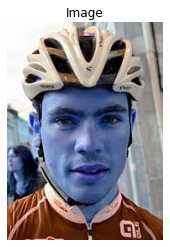

In [69]:
img = helmet_train[0]
show(img)

In [8]:
print(img.size)
print(img.shape)

151050
(265, 190, 3)


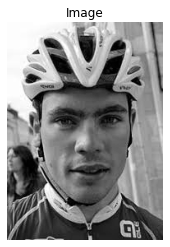

In [10]:
gray = rgb2gray(img)
show(gray)

In [11]:
gray.shape

(265, 190)

In [12]:
gray.mean()

0.4899958731078529

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


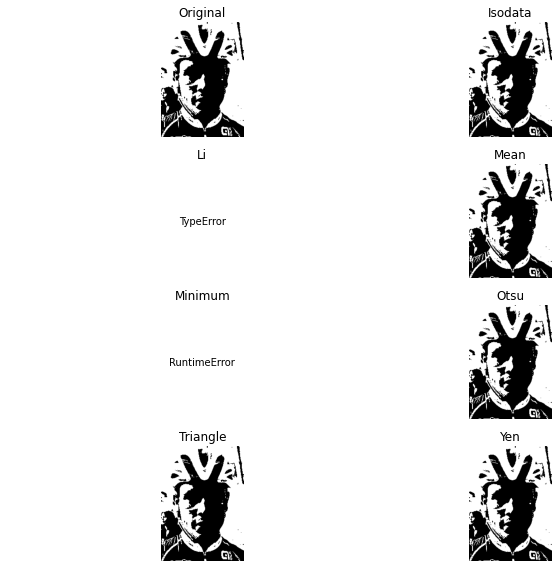

In [15]:
fig, ax = try_all_threshold(bin_img, figsize=(10, 8), verbose=False)

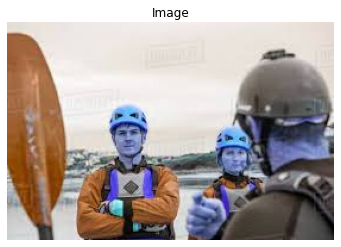

In [133]:
img2 = helmet_train[6]
show(img2)

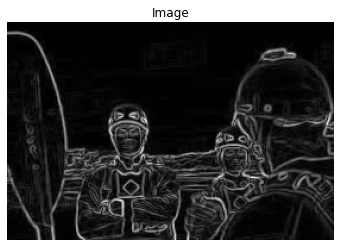

In [134]:
#threshold=threshold_local(rgb2gray(img2), block_size=3, offset=0.003)
bin_img = sobel(rgb2gray(img2))
show(bin_img)

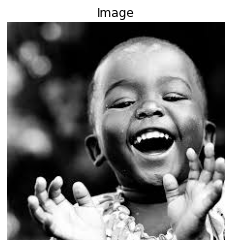

In [187]:
show(X_train[5])

In [257]:
class ImageProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        #self.X=X
        #self.y = y
        pass
    def fit(self, X, y):
        return self
    def transform(self, X, y):
        X_processed = []
        i=0
        for img in X:
            #smoothed = gaussian(img, multichannel=True, sigma=2)
            ++i
            try:
                gray = rgb2gray(img)
                edge_img = sobel(gray)
                pts = np.argwhere(edge_img>0)
                y1,x1 = pts.min(axis=0)
                y2,x2 = pts.max(axis=0)
                cropped = edge_img[y1:y2, x1:x2]
                image = tf.image.convert_image_dtype(cropped, tf.float32)
                #image = np.resize(cropped, (256, 128))
                r = image.shape[0]
                c = image.shape[1]
                if r<128:
                    image = np.append(image, np.zeros([128-r, c]), axis=0)
                else:
                    image = image[:128,:]
                if c<256:
                    image = np.append(image, np.zeros([128, 256-c]), axis=1)
                else:
                    image = image[:,:256]
                X_processed.append(image)
            except:
                #print(i)
                y=np.delete(y,i)
                --i
        return np.array(X_processed), y

In [268]:
processor = ImageProcessor()
processor.fit(X_train, y_train)
X_train, y_train = processor.transform(X_train, y_train)
X_test, y_test = processor.transform(X_test, y_test)

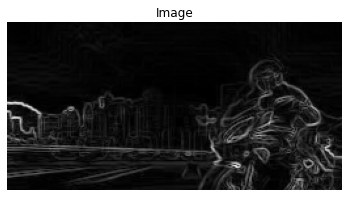

In [271]:
show(X_train[18])

In [282]:
ds_train = X_train.reshape(X_train.shape[0],128,256,1)
ds_test = X_test.reshape(X_test.shape[0],128,256,1)

In [291]:
(ds_train).shape

(702, 128, 256, 1)

### Model 1

In [321]:
model_1 = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=[128,256,1]),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(units=6, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

In [322]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

history_1 = model_1.fit(ds_train, y_train,
          validation_data=(ds_test,y_test),
          epochs=25,
          verbose=1)

Epoch 1/25
22/22 [==============================] - 26s 1s/step - loss: 0.6632 - binary_accuracy: 0.5655 - val_loss: 0.6735 - val_binary_accuracy: 0.5048
Epoch 2/25
22/22 [==============================] - 27s 1s/step - loss: 0.6305 - binary_accuracy: 0.6182 - val_loss: 0.6668 - val_binary_accuracy: 0.5481
Epoch 3/25
22/22 [==============================] - 26s 1s/step - loss: 0.6138 - binary_accuracy: 0.6595 - val_loss: 0.6594 - val_binary_accuracy: 0.5240
Epoch 4/25
22/22 [==============================] - 31s 1s/step - loss: 0.5657 - binary_accuracy: 0.6952 - val_loss: 0.6566 - val_binary_accuracy: 0.6346
Epoch 5/25
22/22 [==============================] - 27s 1s/step - loss: 0.5005 - binary_accuracy: 0.7621 - val_loss: 0.6587 - val_binary_accuracy: 0.6490
Epoch 6/25
22/22 [==============================] - 32s 1s/step - loss: 0.4142 - binary_accuracy: 0.8120 - val_loss: 0.7393 - val_binary_accuracy: 0.6250
Epoch 7/25
22/22 [==============================] - 29s 1s/step - loss: 0.33

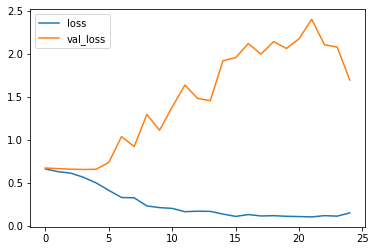

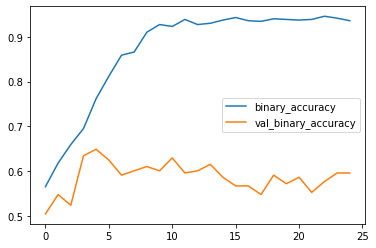

In [324]:
history_frame = pd.DataFrame(history_1.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

### Model 2

In [325]:
model_2 = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=[128,256,1]),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(units=6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])

In [326]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

history_2 = model_2.fit(ds_train, y_train,
          validation_data=(ds_test,y_test),
          epochs=25,
          verbose=1)

Epoch 1/25
22/22 [==============================] - 29s 1s/step - loss: 0.6836 - binary_accuracy: 0.5541 - val_loss: 0.6908 - val_binary_accuracy: 0.4856
Epoch 2/25
22/22 [==============================] - 30s 1s/step - loss: 0.6786 - binary_accuracy: 0.5755 - val_loss: 0.6786 - val_binary_accuracy: 0.4856
Epoch 3/25
22/22 [==============================] - 36s 2s/step - loss: 0.6622 - binary_accuracy: 0.5755 - val_loss: 0.6722 - val_binary_accuracy: 0.4856
Epoch 4/25
22/22 [==============================] - 28s 1s/step - loss: 0.6498 - binary_accuracy: 0.5755 - val_loss: 0.6635 - val_binary_accuracy: 0.4856
Epoch 5/25
22/22 [==============================] - 26s 1s/step - loss: 0.6405 - binary_accuracy: 0.5883 - val_loss: 0.6583 - val_binary_accuracy: 0.5433
Epoch 6/25
22/22 [==============================] - 26s 1s/step - loss: 0.6265 - binary_accuracy: 0.6339 - val_loss: 0.6564 - val_binary_accuracy: 0.5433
Epoch 7/25
22/22 [==============================] - 26s 1s/step - loss: 0.60

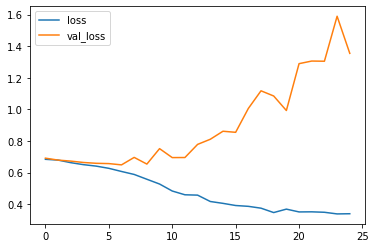

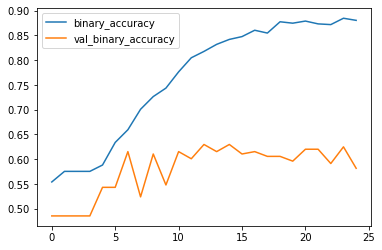

In [327]:
history_frame = pd.DataFrame(history_2.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

### Model 3

In [328]:
model_3 = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=[128,256,1]),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=1, activation='sigmoid')
])

In [319]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

history_3 = model_3.fit(ds_train, y_train,
          validation_data=(ds_test,y_test),
          epochs=10,
          verbose=1)

Epoch 1/10
22/22 [==============================] - 45s 2s/step - loss: 1.0696 - binary_accuracy: 0.5926 - val_loss: 1.0570 - val_binary_accuracy: 0.5144
Epoch 2/10
22/22 [==============================] - 40s 2s/step - loss: 0.5707 - binary_accuracy: 0.7251 - val_loss: 0.7794 - val_binary_accuracy: 0.5144
Epoch 3/10
22/22 [==============================] - 44s 2s/step - loss: 0.4505 - binary_accuracy: 0.7991 - val_loss: 0.9335 - val_binary_accuracy: 0.5144
Epoch 4/10
22/22 [==============================] - 36s 2s/step - loss: 0.3528 - binary_accuracy: 0.8590 - val_loss: 1.0662 - val_binary_accuracy: 0.5144
Epoch 5/10
22/22 [==============================] - 36s 2s/step - loss: 0.2886 - binary_accuracy: 0.8974 - val_loss: 0.7544 - val_binary_accuracy: 0.5144
Epoch 6/10
22/22 [==============================] - 41s 2s/step - loss: 0.2375 - binary_accuracy: 0.9160 - val_loss: 0.8997 - val_binary_accuracy: 0.5144
Epoch 7/10
22/22 [==============================] - 45s 2s/step - loss: 0.20

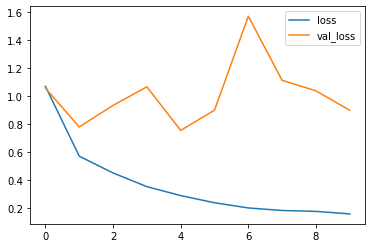

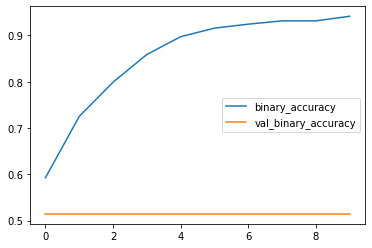

In [320]:
history_frame = pd.DataFrame(history_3.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();